Build a simple CNN Auto-Encoder to color image. 

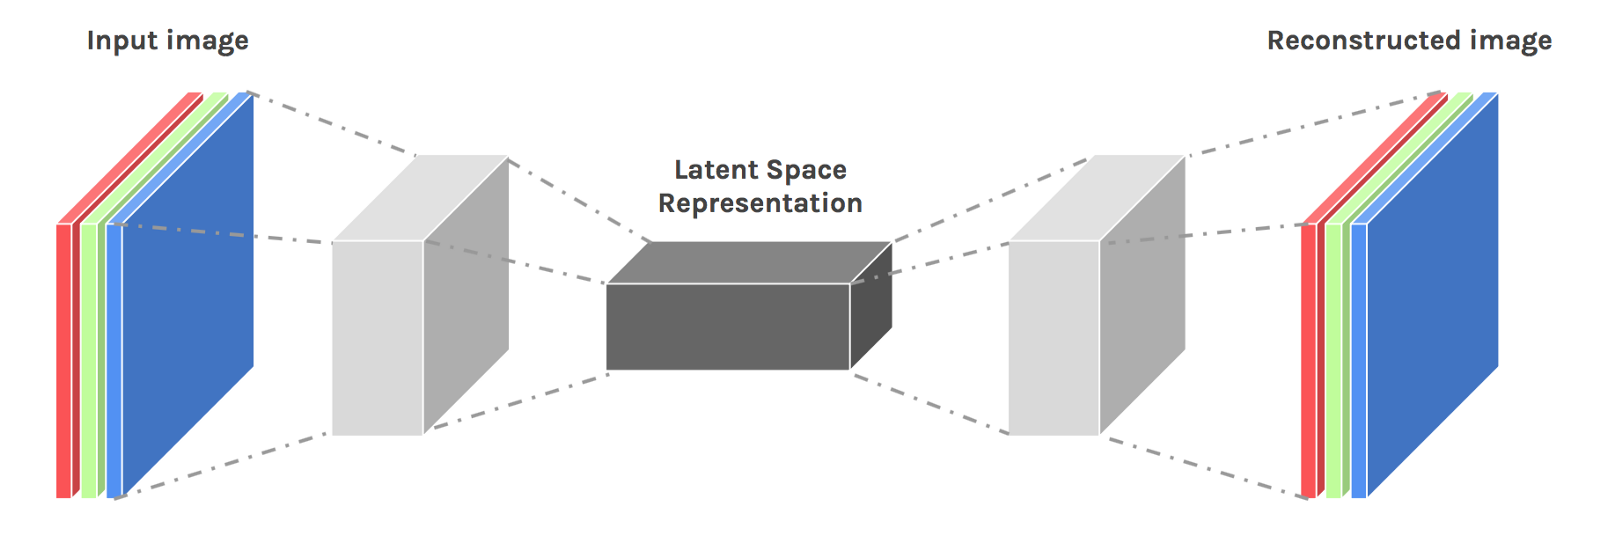

Here 
1. Input image is a black-white image.
2. The latent space is a representation of this image in a smaller dimension. 
3. The Reconstructed image is a color input image. </br>
All this happens as the model compares the reconstructed image with the color image(the one we have). By comparing is to find mean square error(i.e mse(color_image, models_output_color_image)) between images and then back prop to minimize this error.

In [1]:
import torch, os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torch import nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (12,6)

## Download Dataset

In [26]:
import tensorflow as tf

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = data_dir + '/'
if os.path.isfile(data_dir + 'LICENSE.txt'):
  os.remove(data_dir + 'LICENSE.txt')
images_dirs = [data_dir+a+'/' for a in os.listdir(data_dir)]

228818944/228813984 [==============================] - 1s 0us/step


Show color images

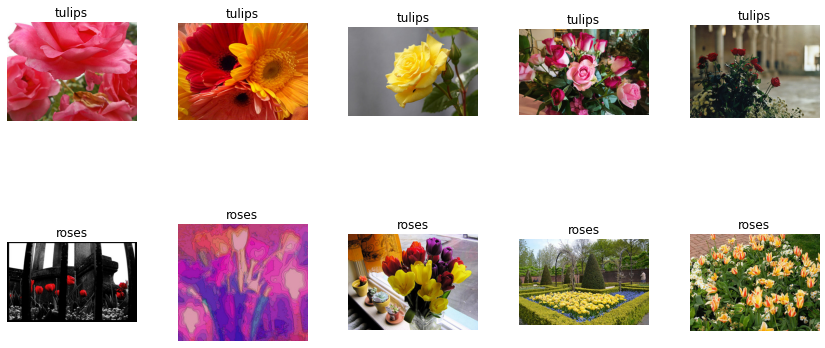

In [ ]:
# sample some images

sample_imgs = [images_dirs[0]+i for i in os.listdir(images_dirs[0])[:5]]
sample_imgs = sample_imgs + [images_dirs[1]+i for i in os.listdir(images_dirs[1])[:5]]
sample_labels = ["tulips"]*5 + ["roses"]*5

r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    im = Image.open(sample_imgs[a])
    axs[i,j].imshow(im)
    axs[i,j].set_title(sample_labels[a])
    axs[i,j].axis('off')
    a+=1

Show b/w images

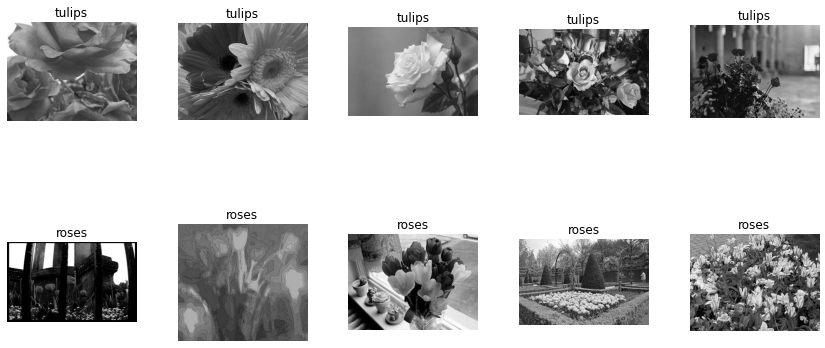

In [ ]:
# sample some images

def rgb2gray(rgb):
    """Convert from color image (RGB) to grayscale.
       Source: opencv.org
       grayscale = 0.299*red + 0.587*green + 0.114*blue
    Argument:
        rgb (tensor): rgb image
    Return:
        (tensor): grayscale image
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

sample_imgs = [images_dirs[0]+i for i in os.listdir(images_dirs[0])[:5]]
sample_imgs = sample_imgs + [images_dirs[1]+i for i in os.listdir(images_dirs[1])[:5]]
sample_labels = ["tulips"]*5 + ["roses"]*5

r,c = 2,5
f, axs = plt.subplots(r,c)
f.tight_layout()
a= 0

for i in range(r):
  for j in range(c):
    im = Image.open(sample_imgs[a])
    im = rgb2gray(np.array(im))
    im = Image.fromarray(im)
    axs[i,j].imshow(im)
    axs[i,j].set_title(sample_labels[a])
    axs[i,j].axis('off')
    a+=1

## Prepare Dataloader

In [27]:
class MakeDataset(Dataset):
    def __init__(self,images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = Image.open(image)
        resized_image = self.transform(image)   

        image = np.array(image)
        bw_image = np.dot(image[...,:3], [0.299, 0.587, 0.114])
        resized_bwimage = self.transform(Image.fromarray(bw_image))  
        resized_bwimage = resized_bwimage / 255.0
        return resized_image, resized_bwimage

In [28]:
BATCH_SIZE = 128

images_paths = []
for p in images_dirs:
  images_paths += [p+a for a in os.listdir(p)]

img_transform = transforms.Compose([    
    transforms.Resize((224, 224)),                              
    transforms.ToTensor()
])
dataset = MakeDataset(images_paths, img_transform)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
dataset[0][0].shape, dataset[0][1].shape

(torch.Size([3, 224, 224]), torch.Size([1, 224, 224]))

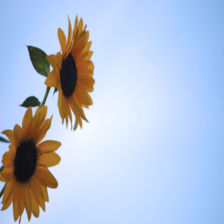

In [ ]:
# sample image from loader
img = dataset[10][0].mul(255).permute(1, 2, 0).byte().numpy()
Image.fromarray(img)

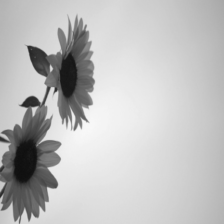

In [ ]:
# sample b/w image from loader
img = dataset[10][1].mul(255).permute(1, 2, 0).byte().numpy().reshape(224,224)
Image.fromarray(img)

To build image coloring auto-encoder, input dimension should be 1 channel for b/w image and the output dimension 3 channels for color image.

In [29]:
# test, check, build auto encoder

print('input shape', dataset[0][1].shape)
x = nn.Conv2d(1, 128, 5, stride=2, padding=1)(dataset[0][1].reshape(1, 1, 224, 224))
x = nn.ReLU()(x)
x = nn.MaxPool2d(kernel_size=2)(x)

x = nn.Conv2d(128, 128, 3, stride=1, padding=1)(x)
x = nn.ReLU()(x)
x = nn.Conv2d(128, 64, 3, stride=1, padding=1)(x)
x = nn.ReLU()(x)

x = nn.Conv2d(64, 64, 3, stride=1, padding=1)(x)
x = nn.ReLU()(x)
x = nn.MaxPool2d(kernel_size=1)(x) 

print('latent space shape', x.shape)

x = nn.ConvTranspose2d(64, 32, 2, stride=2)(x) # input latent space to decoder
x = nn.ReLU()(x)
x = nn.ConvTranspose2d(32, 16, 4, stride=2)(x)
x = nn.ReLU()(x)
x = nn.ConvTranspose2d(16, 8, 2, stride=1)(x)
x = nn.ReLU()(x)
x = nn.ConvTranspose2d(8, 3, 2, stride=1)(x)
print('decoder shape', x.shape) # (decoder output) make sure it is same size as input image

input shape torch.Size([1, 224, 224])
latent space shape torch.Size([1, 64, 55, 55])
decoder shape torch.Size([1, 3, 224, 224])


## Build Auto-Encoder

In [ ]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(nn.Conv2d(1, 128, 5, stride=2, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=2),
                                      nn.Conv2d(128, 128, 3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(128, 64, 3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.Conv2d(64, 64, 3, stride=1, padding=1),
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=1)
                                      )
        
        self.decoder = nn.Sequential(nn.ConvTranspose2d(64, 32, 2, stride=2),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(32, 16, 4, stride=2),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(16, 8, 2, stride=1),
                                      nn.ReLU(),
                                      nn.ConvTranspose2d(8, 3, 2, stride=1),
                                      nn.Tanh() # tanh is faster than sigmoid, we can clip [0,1] later
                                      )

    def forward(self, x):
      x = self.encoder(x)
      x1 = self.decoder(x)
      return x1     

## Training

In [ ]:
%%time

LR = 0.003
epochs = 50 # need more epochs to learn
print_epoch = 10
best_loss = 0.50
model_save_path = "/content/autoencoder1.bin"
model = AutoEncoder().cuda(0)
criterion = nn.MSELoss() # simple MSE loss
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=1e-7)

if os.path.isfile(model_save_path):
  save_m = torch.load(model_save_path)
  model.load_state_dict(save_m['model_state_dict'])
  optimizer.load_state_dict(save_m['optimizer_state'])
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, last_epoch=save_m['prev_epoch'], eta_min=1e-7)
  scheduler.load_state_dict(save_m['scheduler_state'])
  print('loaded')

train_step = len(dataset)/BATCH_SIZE
print("--Training Started--")
for epoch in range(1,epochs+1):
  running_loss = 0.0
  for images, bw_images in dataloader:
    optimizer.zero_grad()
    images, bw_images = images.cuda(0), bw_images.cuda(0)
    output_images = model(bw_images)
    loss = criterion(images, output_images) 
    running_loss+=loss.detach()       
    loss.backward()
    optimizer.step() 
  train_loss = running_loss/train_step

  scheduler.step()
  if train_loss < best_loss:
    best_loss = train_loss
    torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state': optimizer.state_dict(),
            'scheduler_state': scheduler.state_dict(),
            'prev_epoch': epoch
            }, model_save_path)
  if epoch % print_epoch == 0:
    print("Epoch:", epoch)
    print("Train Loss:", train_loss.item())  

print('')    
print("--Training Complete--")    
print("Best loss:", best_loss.item())

--Training Started--
Epoch: 10
Train Loss: 0.021426185965538025
Epoch: 20
Train Loss: 0.019866973161697388
Epoch: 30
Train Loss: 0.01932661049067974
Epoch: 40
Train Loss: 0.018932649865746498
Epoch: 50
Train Loss: 0.018744558095932007

--Training Complete--
Best loss: 0.018731217831373215
CPU times: user 31min 36s, sys: 39.7 s, total: 32min 16s
Wall time: 32min 16s


## Results

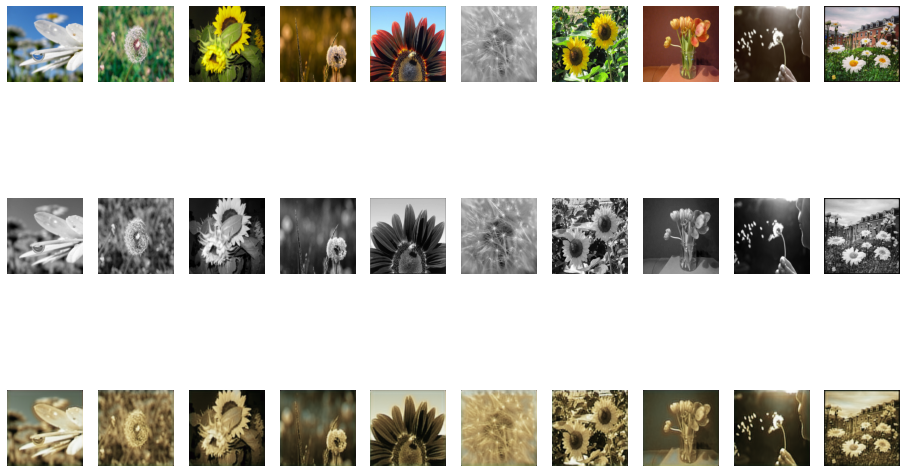

In [ ]:
if os.path.isfile('/content/autoencoder1.bin'):
  model.load_state_dict(torch.load(model_save_path1)["model_state_dict"])
output_images = model(bw_images)
ROWS, COLS = 3, 10
recontructed_samples = []

for image in output_images:
  image = image.clamp(0,1) # instead of sigmoid clip tanh's output to [0,1]
  recontructed_samples.append(image.detach().cpu())
  if len(recontructed_samples) == ROWS*COLS:
    break

f, axs = plt.subplots(ROWS,COLS, figsize=(16,10))
a,b,c= 0,0,0

for i in range(ROWS):
  for j in range(COLS):

    if i == 0:  
      im = images[a].mul(255).permute(1, 2, 0).byte().detach().cpu().numpy() # original image
      axs[i,j].imshow(im)
      a+=1
    elif i == 1:
      im = bw_images[b].mul(255).permute(1, 2, 0).byte().detach().cpu().numpy().reshape(224,224)  # b/w image
      axs[i,j].imshow(im, cmap='gray')
      b+=1
    else:
      im = recontructed_samples[c].mul(255).permute(1, 2, 0).byte().numpy() # colored image
      axs[i,j].imshow(im)
      c+=1

    axs[i,j].axis('off')

Summary: As we can see there are some improvements already, but with more training (100-150 epochs) the results can be even better, actually colored image. Improvements:
1. More Training.
2. Bigger network.
